# Strong (Dirichlet) boundary conditions

Let's move on from the Helmholtz problem to Poisson:

$$-\nabla^2u = f$$

for some known function $f$. To have a well-posed problem, we must impose Dirichlet conditions over at least part of the domain boundary:

$$\begin{gather*}
u(x) = g(x) \quad \forall x \in \Gamma_D,\\
\nabla u(x)\cdot \vec{n} = h(x) \quad \forall x \in \Gamma_N.
\end{gather*}$$

As before, the Neumann condition is imposed weakly by setting the boundary integral over the relevant part of the boundary. The Dirichlet condition is imposed strongly by modifying the function space from which $u$ is drawn.

Suppose $V\ni u$ is a finite element space. Then we write:

$$V_D = \{u\in V \,|\,u(x) = g \quad \forall x \in \Gamma_D\},$$
$$V_0 = \{u\in V \,|\,u(x) = 0 \quad \forall x \in \Gamma_D\}.$$

The weak form of the problem then becomes, find $u\in V_D$ such that:

$$\int_\Omega \nabla u \cdot \nabla v\, \mathrm{d}x - \int_{\Gamma_N} hv\, \mathrm{d}s = \int_\Omega fv\mathrm{d}x \quad\forall v\in V_0.$$

In Firedrake, the weak form is always formulated in the unmodified space $V$. The modification to the function spaces implied by the Dirichlet conditions is then imposed by supplying a [`DirichletBC` object](http://firedrakeproject.org/firedrake.html#firedrake.bcs.DirichletBC) to the solve.

As usual, we start by setting up the notebook matplotlib interaction, and importing Firedrake.  We then choose a triangulation of our domain and select an appropriate $H^1$-conforming function space.

In [1]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window
%matplotlib widget
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [2]:
from firedrake import *
mesh = UnitSquareMesh(10, 10)
V = FunctionSpace(mesh, "Lagrange", 1)

Let us specify the details of our problem.  We will solve

$$ -\nabla^2 u = f \text{ on } \Omega = [0, 1]\times[0, 1], \\
  u = 0 \text{ on } \Gamma.$$
  
We'll choose an $f$ such that the exact solution $u^* = \sin(\pi x)\sin(\pi y)$, which satisfies the zero Dirichlet conditions.  With a little algebra, we determine that we need

$$ f = 2\pi^2\sin(\pi x) \sin(\pi y). $$

In [3]:
x, y = SpatialCoordinate(mesh)
u_exact = sin(pi*x)*sin(pi*y)
f = 2*pi**2*u_exact

As before, we'll require test and trial functions to define our problem.

In [4]:
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v))*dx
L = f*v*dx

Now we need to tell Firedrake how to modify the function space to take into account the Dirichlet condition.  This is done by constructing a [DirichletBC object](http://firedrakeproject.org/firedrake.html#firedrake.bcs.DirichletBC).  As usual, we can ask for help using Python's builtin documentation facilities.

In [5]:
?DirichletBC

Init signature: DirichletBC(V, g, sub_domain, method=None)
Docstring:     
Implementation of a strong Dirichlet boundary condition.

.. note:

   This uses facet markers in the domain, so may be used to
   applied strong boundary conditions to interior facets (if they
   have an appropriate mesh marker). The "on_boundary" string only
   applies to the exterior boundaries of the domain.

:arg V: the :class:`.FunctionSpace` on which the boundary condition
    should be applied.
:arg g: the boundary condition values. This can be a :class:`.Function` on
    ``V``, or a UFL expression that can be interpolated into
    ``V``, for example, a :class:`.Constant` , an iterable of
    literal constants (converted to a UFL expression), or a
    literal constant which can be pointwise evaluated at the nodes
    of ``V``.
:arg sub_domain: the integer id(s) of the boundary region over which the
    boundary condition should be applied. The string "on_boundary" may be used
    to indicate all of the b

We want to apply the zero Dirichlet condition to all exterior nodes of the space, so we need to provide the list of boundary ids that corresponds to the exterior boundary of the domain.  For the `UnitSquareMesh`, this is the set `(1, 2, 3, 4)`.

In [6]:
boundary_ids = (1, 2, 3, 4)
bcs = DirichletBC(V, 0, boundary_ids)

We supply the boundary condition as an argument to `solve`.

In [7]:
uh = Function(V)
solve(a == L, uh, bcs=bcs)

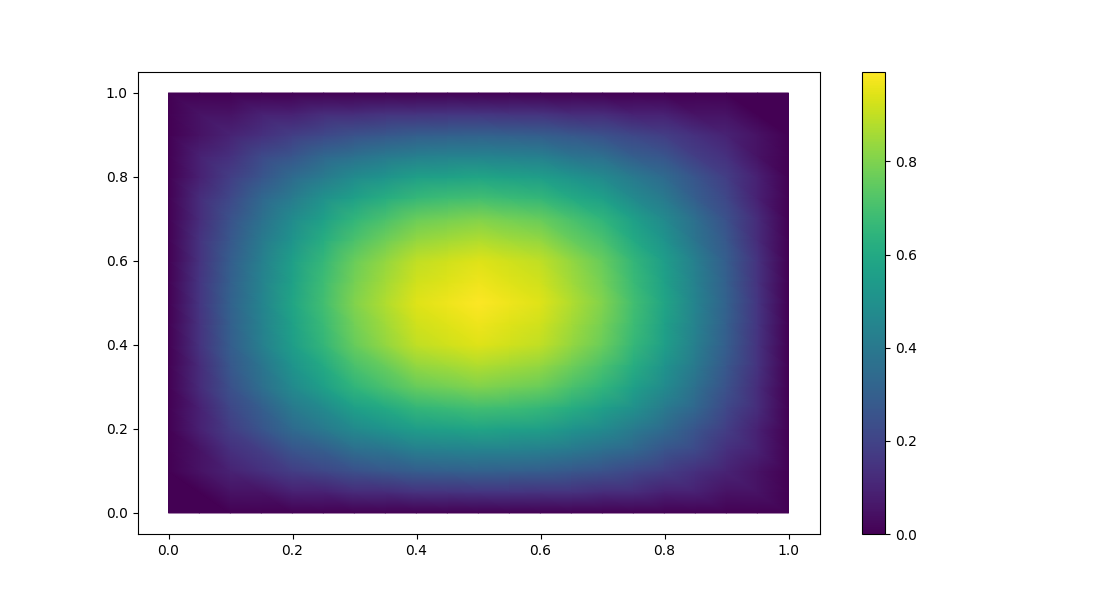

In [8]:
# NBVAL_IGNORE_OUTPUT
from firedrake.pyplot import tripcolor

fig, axes = plt.subplots()
collection = tripcolor(uh, axes=axes)
fig.colorbar(collection);

# Exercises

Most of the time, we don't want to impose the same Dirichlet condition everywhere.  Instead of solving with homogeneous Dirichlet conditions everywhere, solve the following problem.

Find $u$ such that

$$ -\nabla^2 u = 0 \text{ in } \Omega = [0, 1]\times[0, 1], \\
   u = 1 \text{ on } \Gamma_1, \\
   u = 2 \text{ on } \Gamma_2, \\
   \nabla u \cdot \vec{n} = 0 \text{ on } \Gamma \setminus (\Gamma_1 \cup \Gamma_2),$$
where $\Gamma_1$ is the plane $y = 0$ and $\Gamma_2$ is the plane $y = 1$.

- Hint 1: To provide a zero right hand side, you'll need to write `Constant(0)*v*dx`.
- Hint 2: Use help to remind youself of the boundary markers for meshes.
- Hint 3: The bcs argument to `solve` can be a list of boundary conditions.
- Hint 4: You can check your answer against the exact solution $u^* = 1 + y$.